In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import numpy as np

from fpl_data_retrieval import get_fpl_data, get_current_gameweek
from basic_set_and_forget_optimisation import simulate_model_team

In [75]:
year = '2023-2024'
team_df = pd.read_csv('optimal_teams/set_and_forget_' + year + '.csv')
display(team_df)

,id,web_name,positions,now_cost,start_cost,short_name,total_points,gw_1_points,gw_1_minutes,gw_2_points,...,gw_36_points,gw_36_minutes,gw_37_points,gw_37_minutes,gw_38_points,gw_38_minutes,in_lineup,on_bench,is_captain,is_vice_captain
0,263,Pickford,GK,48,45,EVE,153,2,90,0,...,3,90,8,90,1,90,True,False,False,True
1,20,Saliba,DEF,59,50,ARS,164,5,90,8,...,6,90,9,90,2,90,True,False,False,False
2,29,White,DEF,61,55,ARS,182,1,90,7,...,6,90,6,90,2,68,True,False,False,False
3,506,Pedro Porro,DEF,59,50,TOT,136,0,0,6,...,0,90,10,180,14,75,True,False,False,False
4,362,Palmer,MID,63,50,CHE,244,1,10,0,...,8,88,14,180,6,88,True,False,True,False
5,353,Foden,MID,85,75,MCI,230,3,90,9,...,5,79,11,171,15,90,True,False,False,False
6,412,Gordon,MID,64,55,NEW,183,4,67,0,...,6,84,8,180,0,0,True,False,False,False
7,516,Son,MID,100,90,TOT,213,2,74,3,...,7,90,4,180,7,87,True,False,False,False
8,19,Saka,MID,88,85,ARS,226,10,90,3,...,10,85,2,81,0,0,True,False,False,False
9,60,Watkins,FWD,89,80,AVL,228,5,90,5,...,2,90,5,90,2,68,True,False,False,False


In [76]:
simulated_team_season = simulate_model_team(team_df)
print(simulated_team_season)

[{1: {'points': 48, 'subs_made': [{'sub_out': 506, 'sub_in': 616}], 'did_captain_play': True, 'vice_play_in_captains_place': False}}, {2: {'points': 48, 'subs_made': [{'sub_out': 362, 'sub_in': 85}], 'did_captain_play': False, 'vice_play_in_captains_place': True}}, {3: {'points': 47, 'subs_made': [{'sub_out': 362, 'sub_in': 245}], 'did_captain_play': False, 'vice_play_in_captains_place': True}}, {4: {'points': 63, 'subs_made': [], 'did_captain_play': True, 'vice_play_in_captains_place': False}}, {5: {'points': 46, 'subs_made': [], 'did_captain_play': True, 'vice_play_in_captains_place': False}}, {6: {'points': 75, 'subs_made': [], 'did_captain_play': True, 'vice_play_in_captains_place': False}}, {7: {'points': 86, 'subs_made': [], 'did_captain_play': True, 'vice_play_in_captains_place': False}}, {8: {'points': 74, 'subs_made': [{'sub_out': 412, 'sub_in': 245}, {'sub_out': 19, 'sub_in': 85}], 'did_captain_play': True, 'vice_play_in_captains_place': False}}, {9: {'points': 69, 'subs_made

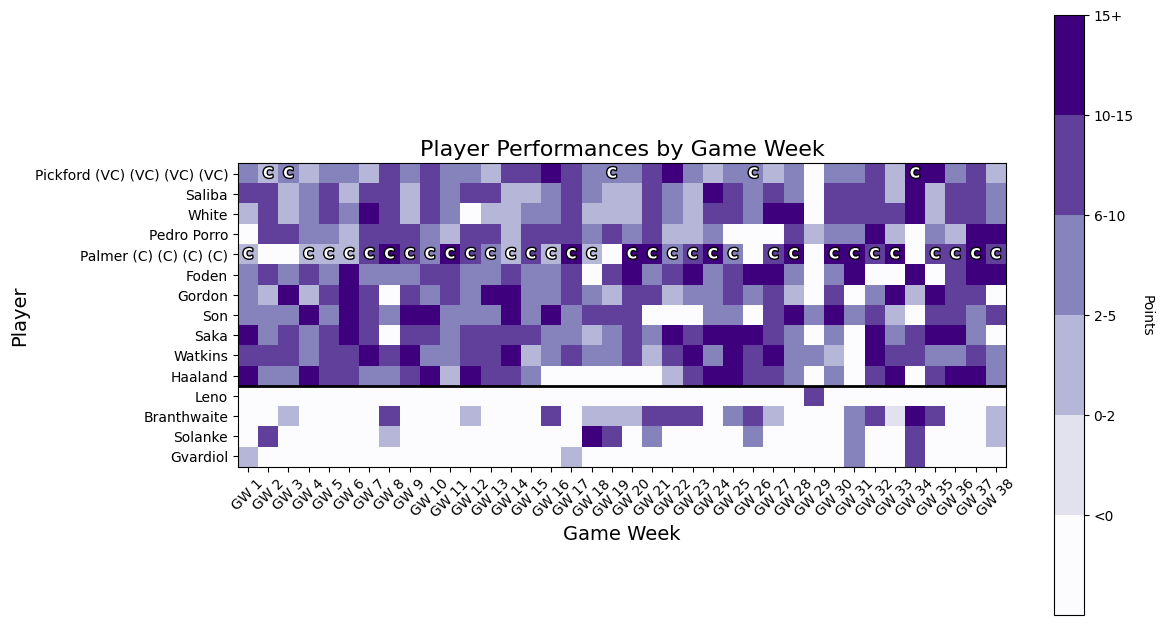

In [80]:
def add_captaincy_vice_captaincy_to_web_name(df):
    """
    Adds the captaincy and vice captaincy to the web_name column

    Args:
        df (pd.DataFrame): The dataframe to add the captaincy and vice captaincy to.

    Returns:
        pd.DataFrame: The dataframe with the captaincy and vice captaincy added to the web_name column.
    """
    # If the row is true for 'is_captain' append (C) to the web_name, if true for 'is_vice_captain' append (VC) to the web_name.
    df['web_name'] = df.apply(lambda row: row['web_name'] + ' (C)' if row['is_captain'] else row['web_name'], axis=1)
    df['web_name'] = df.apply(lambda row: row['web_name'] + ' (VC)' if row['is_vice_captain'] else row['web_name'], axis=1)
    return df

def get_point_range(df):
    """
    Gets the min and max of points in a single gameweek

    Args:
        df (pd.DataFrame): The dataframe to get the point range from.

    Returns:
        tuple: The min and max of points in a single gameweek
    """
    # Get the min and max of points across all game weeks
    for i in range(1, get_current_gameweek(get_fpl_data()) + 1):
        if i == 1:
            min_points = df[f'gw_{i}_points'].min()
            max_points = df[f'gw_{i}_points'].max()
        else:
            min_points = min(min_points, df[f'gw_{i}_points'].min())
            max_points = max(max_points, df[f'gw_{i}_points'].max())
    return min_points, max_points

def visualise_player_point_breakdown(df):
    current_gw = get_current_gameweek(get_fpl_data())
    
    # Define bins and colors
    bins = [-1, 0, 2, 5, 10, 15, np.inf]
    colors = plt.cm.Purples(np.linspace(0, 1, 6))
    bin_labels = ['<0', '0-2', '2-5', '6-10', '10-15', '15+']

    # Create a matrix to hold the values for the grid
    grid_data = np.full((len(df), current_gw), -1)

    # Fill the matrix with the player's points for each game week
    for i, row in df.iterrows():
        for j in range(1, current_gw + 1):
            gw_points_col = f"gw_{j}_points"
            gw_minutes_col = f"gw_{j}_minutes"
            gw_in_team_col = f"gw_{j}_in_team"
            if row[gw_in_team_col] and pd.notnull(row[gw_points_col]) and row[gw_minutes_col] > 0:
                points = row[gw_points_col]
                bin_index = np.digitize(points, bins) - 1
                grid_data[i, j-1] = bin_index

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(12, 8))

    # Create a colormap from the colors
    cmap = plt.cm.colors.ListedColormap(colors)
    
    # Plot the grid using imshow
    im = ax.imshow(grid_data, cmap=cmap, vmin=-1, vmax=len(bins)-2) 

    # Add a colorbar with the bin labels
    cbar = plt.colorbar(im, ax=ax, ticks=np.arange(len(colors)))
    cbar.ax.set_yticklabels(bin_labels)
    cbar.ax.set_ylabel('Points', rotation=-90, va="bottom")

    # Set the title and labels
    ax.set_title("Player Performances by Game Week", fontsize=16)
    ax.set_xlabel("Game Week", fontsize=14)
    ax.set_ylabel("Player", fontsize=14)

    # Add tick marks and labels for players
    ax.set_yticks(np.arange(len(df)))
    ax.set_yticklabels(df['web_name'], fontsize=10)

    # Add tick marks and labels for game weeks
    ax.set_xticks(np.arange(current_gw))
    ax.set_xticklabels([f"GW {i+1}" for i in range(current_gw)], fontsize=10, rotation=45)

    # Add a solid black line between the bench players and the lineup players
    bench_start = df[df['in_lineup'] == False].index[0]
    ax.axhline(bench_start - 0.5, color='black', linewidth=2)

    # Add 'C' for captain's cells and vice-captain's cells
    for i, row in df.iterrows():
        for j in range(1, current_gw + 1):
            gw_in_team_col = f"gw_{j}_in_team"
            gw_points_col = f"gw_{j}_points"
            gw_minutes_col = f"gw_{j}_minutes"
            if row[gw_in_team_col] and pd.notnull(row[gw_points_col]) and row[gw_minutes_col] > 0:
                if row['is_captain']:
                    text = ax.text(j-1, i, 'C', ha='center', va='center', color='w', fontweight='bold')
                    text.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='k')])
                elif row['is_vice_captain'] and not df.loc[df['is_captain'], gw_in_team_col].any():
                    text = ax.text(j-1, i, 'C', ha='center', va='center', color='w', fontweight='bold')
                    text.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='k')])

    # Adjust the spacing between subplots
    plt.subplots_adjust(left=0.15, right=0.95, bottom=0.15, top=0.9)

    # Display the plot
    plt.show()

# Assuming engineered_df is already defined and populated
visualise_player_point_breakdown(add_captaincy_vice_captaincy_to_web_name(engineered_df))